In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import datetime as dt
import pandas as pd
import f90nml
import matplotlib.dates as mdates
import netCDF4 as nc

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = ','.join(r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

## Mesozooplankton
      REAL(wp), dimension (1:3) :: zz_rate_mesozoo_sumpeakval !uM N magnitude of mesozooplankton summer concentration peaks
      REAL(wp), dimension (1:3) :: zz_rate_mesozoo_sumpeakpos ! year-day times of mesozooplankton summer concentration peaks
      REAL(wp), dimension (1:3) :: zz_rate_mesozoo_sumpeakwid ! year-days widths of mesozooplankton summer concentration peaks

In [2]:
nml=f90nml.read('/data/eolson/results/MEOPAR/biomodelevalpaper/modParams/namelist_smelt_ref')
nmlold=f90nml.read('/data/eolson/results/MEOPAR/biomodelevalpaper/modParams/namelist_smelt_ref_old') # for now just load the same one

In [3]:
#&nampismezo     !   parameters for microzooplankton
winterconc       = nml['nampismezo']['zz_rate_mesozoo_winterconc']       #uM N mesozooplankton background concentration
summerconc       = 1.0         # uM N mesozooplankton relative summer concentration
sumpeakval = np.expand_dims(nml['nampismezo']['zz_rate_mesozoo_sumpeakval'],0)      #uM N magnitude of mesozooplankton summer concentration peaks
sumpeakpos = np.expand_dims(nml['nampismezo']['zz_rate_mesozoo_sumpeakpos'],0)   # year-day times of mesozooplankton summer concentration peaks
sumpeakwid = np.expand_dims(nml['nampismezo']['zz_rate_mesozoo_sumpeakwid'],0)   # year-days widths of mesozooplankton summer concentration peaks,0)

#&nampismezo     !   parameters for microzooplankton
winterconc_old       = nmlold['nampismezo']['zz_rate_mesozoo_winterconc']       #uM N mesozooplankton background concentration
summerconc_old       = 1.0         # uM N mesozooplankton relative summer concentration
sumpeakval_old = np.expand_dims(nmlold['nampismezo']['zz_rate_mesozoo_sumpeakval'],0)      #uM N magnitude of mesozooplankton summer concentration peaks
sumpeakpos_old = np.expand_dims(nmlold['nampismezo']['zz_rate_mesozoo_sumpeakpos'],0)   # year-day times of mesozooplankton summer concentration peaks
sumpeakwid_old = np.expand_dims(nmlold['nampismezo']['zz_rate_mesozoo_sumpeakwid'],0)   # year-days widths of mesozooplankton summer concentration peaks,0)

In [4]:
maxRate=nml['nampismezo']['zz_rate_mesozoo_r']
# check that grazing rate has been unchanged since original run:
if not maxRate==1.39e-5:
    print('PROBLEM: GRAPH BELOW WILL BE INCORRECT BECAUSE GRAZING RATES ARE NOT CONSISTENT')
else: 
    print('rates ok')

rates ok


In [5]:
zz_day=np.arange(1,367) # in model, nday_year starts at 1 on jan 1
dts=[dt.datetime(2014,12,31)+dt.timedelta(days=float(ii)) for ii in zz_day]
zz_day=np.expand_dims(zz_day,1)

MesZoBar = winterconc + \
        summerconc*(np.sum ( sumpeakval * np.exp(-(zz_day-sumpeakpos)**2/sumpeakwid**2),1) \
                    + np.sum ( sumpeakval * np.exp( -(zz_day-sumpeakpos-365.25)**2/sumpeakwid**2),1) \
                    + np.sum ( sumpeakval * np.exp( -(zz_day-sumpeakpos+365.25)**2/sumpeakwid**2),1) )
    
MesZoBar_old = winterconc_old + \
        summerconc_old*(np.sum ( sumpeakval_old * np.exp(-(zz_day-sumpeakpos_old)**2/sumpeakwid_old**2),1) \
                    + np.sum ( sumpeakval_old * np.exp( -(zz_day-sumpeakpos_old-365.25)**2/sumpeakwid_old**2),1) \
                    + np.sum ( sumpeakval_old * np.exp( -(zz_day-sumpeakpos_old+365.25)**2/sumpeakwid_old**2),1) )

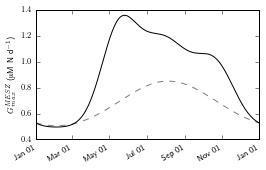

In [6]:
fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.plot(dts,MesZoBar_old*maxRate*24*3600,'--',color='grey')
ax.plot(dts,MesZoBar*maxRate*24*3600,'-',color='k')
ax.set_ylabel('$G_{max}^{MESZ}$ ($\muup$M N d$^{-1}$)')
#ax.set_xlabel('Date')
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')
yearsFmt = mdates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(yearsFmt)
fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsMod/mesozoo.eps',dpi=400,transparent=True)

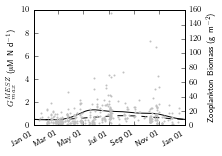

In [7]:
##version with data
df=pd.read_excel('/ocean/eolson/MEOPAR/obs/MackasZoop/1-s2.0-S007966111300061X-mmc2.xls',skiprows=1)
df=df.dropna(0,how='any', subset=['Year','Month','Day']).dropna(1,how='any',thresh=200)
yd=[(dt.datetime(int(r.Year),int(r.Month),int(r.Day))-dt.datetime(int(r.Year)-1,12,31)).days for i,r in df.iterrows()]
df=df.assign(yd=yd).sort_values(by='yd')
dtsdf=[dt.datetime(2014,12,31)+dt.timedelta(days=int(ii)) for ii in df['yd'].values]
df['dts']=dtsdf

fig,ax=plt.subplots(1,1,figsize=(3,2))

p2,=ax.plot(dts,MesZoBar_old*maxRate*24*3600,'--',color='k',label='this study')
p1,=ax.plot(dts,MesZoBar*maxRate*24*3600,'-',color='k',label='Moore-Maley et al. (2016)')
ax.set_ylabel('$G_{max}^{MESZ}$ ($\muup$M N d$^{-1}$)')
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')
yearsFmt = mdates.DateFormatter('%b %d')
ax.set_ylim(0,10)
ax.xaxis.set_major_formatter(yearsFmt)
ax2=ax.twinx()
p3,=ax2.plot(df.loc[:,['dts']],df.loc[:,['Total Biomass']],'.',color='silver', MarkerEdgeWidth=0,MarkerSize=4,label='Mackas et al. (2013)')
ax2.set_ylabel('Zooplankton Biomass (g m$^{-2}$)')
ax2.set_ylim()
ax.set_position(pos=(0.15,.16,.7,.8))
ax2.set_position(pos=(0.15,.16,.7,.8))
#fig.legend((p1,p2,p3),('this study','Moore-Maley et al. (2016)','Mackas et al. (2013)'),loc=2)
#fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsMod/mesozooWithMackas.eps',dpi=400,transparent=True)

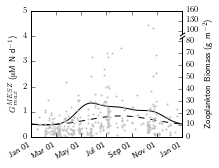

In [8]:
##version with data
df=pd.read_excel('/ocean/eolson/MEOPAR/obs/MackasZoop/1-s2.0-S007966111300061X-mmc2.xls',skiprows=1)
df=df.dropna(0,how='any', subset=['Year','Month','Day']).dropna(1,how='any',thresh=200)
yd=[(dt.datetime(int(r.Year),int(r.Month),int(r.Day))-dt.datetime(int(r.Year)-1,12,31)).days for i,r in df.iterrows()]
df=df.assign(yd=yd).sort_values(by='yd')
dtsdf=[dt.datetime(2014,12,31)+dt.timedelta(days=int(ii)) for ii in df['yd'].values]
df['dts']=dtsdf

fig,(ax,ax1,ax2)=plt.subplots(3,1,figsize=(3,2.2),sharex=True)
ax.yaxis.tick_left()
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
for iax in (ax,ax1,ax2):
    iax.patch.set_alpha(0)
p2,=ax.plot(dts,MesZoBar_old*maxRate*24*3600,'--',color='k',label='this study')
p1,=ax.plot(dts,MesZoBar*maxRate*24*3600,'-',color='k',label='Moore-Maley et al. (2016)')
ax.set_ylabel('$G_{max}^{MESZ}$ ($\muup$M N d$^{-1}$)')
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')
yearsFmt = mdates.DateFormatter('%b %d')
ax.set_ylim(0,5)
ax.xaxis.set_major_formatter(yearsFmt)
#ax2=ax.twinx()
p3,=ax1.plot(df.loc[:,['dts']],df.loc[:,['Total Biomass']],'.',color='silver', MarkerEdgeWidth=0,MarkerSize=4,label='Mackas et al. (2013)')
ax2.plot(df.loc[:,['dts']],df.loc[:,['Total Biomass']],'.',color='silver', MarkerEdgeWidth=0,MarkerSize=4,label='Mackas et al. (2013)')
ax2.set_ylabel('Zooplankton Biomass (g m$^{-2}$)')
#ax1.set_ylim()
ax.set_position(pos=(0.15,.15,.7,.8))
ax2.set_position(pos=(0.15,.15,.7,.63))
ax1.set_position(pos=(0.15,.8,.7,.15))
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax.xaxis.tick_bottom()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax1.set_ylim(90,160)
ax1.set_yticks((100,130,160))
ax2.set_ylim(0,83)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
a=.6/.15
ax1.plot((1 - d, 1 + d), (-d*a, +d*a), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax2.yaxis.set_label_coords(1.14,.63)
#fig.legend((p1,p2,p3),('this study','Moore-Maley et al. (2016)','Mackas et al. (2013)'),loc=2)
fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsMod/mesozooWithMackas.eps',dpi=400,transparent=True)

In [9]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'][0,0,:,:])
    navlon=np.copy(fm.variables['nav_lon'][:,:])
    navlat=np.copy(fm.variables['nav_lat'][:,:])

(48.7, 50.1)

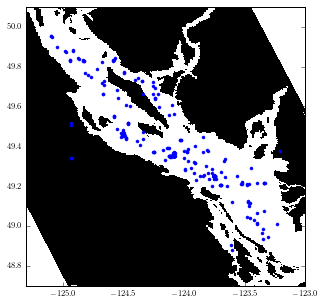

In [10]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(navlon,navlat,tmask,cmap=plt.get_cmap('Greys_r'))
plt.plot(-1*df['Longitude (deg W)'],df['Latitude (deg N)'],'b.')
ax.set_xlim(-125.3,-123)
ax.set_ylim(48.7,50.1)